Let's first install and import the necessary packages for this colab.


In [1]:
!pip install -q tensorflow==1.15.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

We can generate the data for this as follows:


## Movielens latest small

### Data processing

The data processing procedure follows a similar procedure as the [basic ranking tutorial](https://www.tensorflow.org/recommenders/examples/basic_ranking).

In [4]:
ratings = tfds.load('movielens/1m-ratings', split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1000209 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/1000209 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /home/ec2-user/tensorflow_datasets/movielens/1m-ratings/0.1.0. Subsequent calls will reuse this data.


In [3]:
# ratings = tfds.load('movielens/latest-small-ratings', split="train")
# movies = tfds.load('movielens/latest-small-movies', split="train")

# # Select the basic features.
# ratings = ratings.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "user_id": x["user_id"],
#     "timestamp": int(x["timestamp"]),
#     "user_rating": x["user_rating"]
# })
# movies = movies.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "movie_title": x["movie_title"]
# })

In [5]:
# for x in movies.take(1).as_numpy_iterator():
#   pprint.pprint(x)

In [5]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 35.0,
 'movie_genres': array([0, 7]),
 'movie_id': b'3107',
 'movie_title': b'Backdraft (1991)',
 'timestamp': 977432193,
 'user_gender': True,
 'user_id': b'130',
 'user_occupation_label': 18,
 'user_occupation_text': b'technician/engineer',
 'user_rating': 5.0,
 'user_zip_code': b'50021'}


In [6]:
# ratings = ratings.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "user_id": x["user_id"],
#     "user_rating": x["user_rating"],
#     "user_gender": int(x["user_gender"]),
#     "user_zip_code": x["user_zip_code"],
#     "user_occupation_text": x["user_occupation_text"],
#     "movie_title": x["movie_title"],
#     "timestamp": int(x["timestamp"]),
#     "bucketized_user_age": int(x["bucketized_user_age"]),
# })

ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

In [5]:
# ratings = tfds.load("movie_lens/100k-ratings", split="train")
# ratings = ratings.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "user_id": x["user_id"],
#     "user_rating": x["user_rating"],
#     "user_gender": int(x["user_gender"]),
#     "user_zip_code": x["user_zip_code"],
#     "user_occupation_text": x["user_occupation_text"],
#     "bucketized_user_age": int(x["bucketized_user_age"]),
# })

Next, we randomly split the data into 90% for training and 10% for testing.


In [7]:
1000209*80/100

800167.2

In [8]:
print(ratings.cardinality().numpy())

1000209


In [9]:
train_size = ratings.cardinality().numpy()*90//100
test_size = ratings.cardinality().numpy()*10//100

print(train_size,test_size)

900188 100020


In [10]:
test_size = 100021

In [11]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(10_00_209, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

Then, we create vocabulary for each feature.

In [12]:
%%time

# feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
#                  "user_occupation_text", "movie_title", "timestamp", "bucketized_user_age",]

feature_names = ["movie_id", "user_id"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))
#print(vocabularies)

Cause: could not parse the source code of <function <lambda> at 0x7f757a45e488>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f757a45e488>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f757a45e488>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f75549306a8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f75549306a8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7f75549306a8>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 3min 20s, sys: 1min 4s, total: 4min 25s
Wall time: 50.1 s


### Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [13]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

#     str_features = ["movie_id", "user_id", "user_zip_code", "movie_title",
#                     "user_occupation_text"]
#     int_features = ["timestamp","user_gender", "bucketized_user_age"]
    
    str_features = ["movie_id", "user_id"]
    int_features = []

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

### Model training
We shuffle, batch and cache the training and test data. 


In [14]:
cached_train = train.shuffle(10_00_209).batch(8192).cache()
cached_test = test.batch(4096).cache()

Let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs.

In [15]:
def run_models(use_cross_layer, deep_layer_sizes, auto_encoder_sizes=None, projection_dim=None, num_runs=5, parallel=False, regularization=None,learning_rate=0.01):
  models = []
  rmses = []

  for i in range(num_runs):
    if not parallel:
      model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    else:
      model = DCN_parallel(deep_layer_sizes=deep_layer_sizes,auto_encoder_sizes=auto_encoder_sizes,
                projection_dim=projection_dim, regularization=regularization)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. Note that these hyper-parameters are set globally for all the models for demonstration purpose. If you want to obtain the best performance for each model, or conduct a fair comparison among models, then we'd suggest you to fine-tune the hyper-parameters. Remember that the model architecture and optimization schemes are intertwined.

In [16]:
epochs = 8
learning_rate = 0.01

**DCN (stacked).** We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1X8qoMtIYKJz4yBYifvfw4QpAwrjr70e_" width="140"/>
</center>
</div>


In [17]:
dcn_result = run_models(use_cross_layer=True, deep_layer_sizes=[192, 192])

25/25 [==============================] - 0s 4ms/step - RMSE: 0.9101 - loss: 0.8284 - regularization_loss: 0.0000e+00 - total_loss: 0.8284


**Low-rank DCN.** To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument `projection_dim`; a smaller `projection_dim` results in a lower cost. Note that `projection_dim` needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1ZZfUTNdxjGAaAuwNrweKkLJ1PGxMmiCm" width="400"/>
</center>
</div>


In [18]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

25/25 [==============================] - 0s 4ms/step - RMSE: 0.8943 - loss: 0.8007 - regularization_loss: 0.0000e+00 - total_loss: 0.8007


**DNN.** We train a same-sized DNN model as a reference.

In [19]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

25/25 [==============================] - 0s 4ms/step - RMSE: 0.9004 - loss: 0.8115 - regularization_loss: 0.0000e+00 - total_loss: 0.8115


Parallel

#### hide

In [26]:
# class DCN_parallel(tfrs.Model):

#   def __init__(self, deep_layer_sizes, projection_dim=None):
#     super().__init__()
#     self.embedding_dimension = 32

#     # str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
#     # int_features = ["user_gender", "bucketized_user_age"]

#     str_features = ["movie_id", "user_id"]
#     int_features = ["timestamp"]


#     self._all_features = str_features + int_features
#     self._embeddings = {}

#     # Compute embeddings for string features.
#     for feature_name in str_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.experimental.preprocessing.StringLookup(
#               vocabulary=vocabulary, mask_token=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])
      
#     # Compute embeddings for int features.
#     for feature_name in int_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.experimental.preprocessing.IntegerLookup(
#               vocabulary=vocabulary, mask_value=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])

#     self._cross_layer = tfrs.layers.dcn.Cross(
#           projection_dim=projection_dim,
#           kernel_initializer="glorot_uniform",name="cross_layer")
    
#     self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu", name="deep_layer")
#       for layer_size in deep_layer_sizes]

#     self._concat_layers = tf.keras.layers.concatenate

#     self._logit_layer = tf.keras.layers.Dense(1, name="output_layer")

#     self.task = tfrs.tasks.Ranking(
#       loss=tf.keras.losses.MeanSquaredError(),
#       metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
#     )

#   def call(self, features):
#     # Concatenate embeddings
#     embeddings = []
#     for feature_name in self._all_features:
#       embedding_fn = self._embeddings[feature_name]
#       embeddings.append(embedding_fn(features[feature_name]))

#     inp = tf.concat(embeddings, axis=1)

#     print(inp)

#     # Build Cross Network
#     x = self._cross_layer(inp)
    
#     # Build Deep Network 
#     for i,deep_layer in enumerate(self._deep_layers):
#       if i==0:
#         y = deep_layer(inp)
#       else:
#         y = deep_layer(y)

#     # Merge both network
#     out = self._concat_layers([x,y])
    
#     out = self._logit_layer(out)
#     return out

#   def compute_loss(self, features, training=False):
#     labels = features.pop("user_rating")
#     scores = self(features)
#     return self.task(
#         labels=labels,
#         predictions=scores,
#     )


#### Parallel with encoders

In [17]:
# class DCN_parallel(tfrs.Model):

#   def __init__(self, deep_layer_sizes, auto_encoder_sizes, projection_dim=None):
#     super().__init__()
#     self.embedding_dimension = 32

#     # str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
#     # int_features = ["user_gender", "bucketized_user_age"]

#     str_features = ["movie_id", "user_id", "user_zip_code", "movie_title",
#                     "user_occupation_text"]
#     int_features = ["timestamp","user_gender", "bucketized_user_age"]


#     self._all_features = str_features + int_features
#     self._embeddings = {}

#     # Compute embeddings for string features.
#     for feature_name in str_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.experimental.preprocessing.StringLookup(
#               vocabulary=vocabulary, mask_token=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])
      
#     # Compute embeddings for int features.
#     for feature_name in int_features:
#       vocabulary = vocabularies[feature_name]
#       self._embeddings[feature_name] = tf.keras.Sequential(
#           [tf.keras.layers.experimental.preprocessing.IntegerLookup(
#               vocabulary=vocabulary, mask_value=None),
#            tf.keras.layers.Embedding(len(vocabulary) + 1,
#                                      self.embedding_dimension)
#     ])

#     self._cross_layer = tfrs.layers.dcn.Cross(
#           projection_dim=projection_dim,
#           kernel_initializer="glorot_uniform",name="cross_layer")
    
#     self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu", name="deep_layer")
#       for layer_size in deep_layer_sizes]
    
#     self.auto_encoder_sizes = auto_encoder_sizes

#     if self.auto_encoder_sizes is not None:
#       self._autoencoders_layers = [tf.keras.layers.Dense(layer_size, activation="relu", name="autoencoder_layer")
#       for layer_size in self.auto_encoder_sizes]

#     self._concat_layers = tf.keras.layers.concatenate

#     self._logit_layer = tf.keras.layers.Dense(1, name="output_layer")

#     self.task = tfrs.tasks.Ranking(
#       loss=tf.keras.losses.MeanSquaredError(),
#       metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
#     )

#   def call(self, features):
#     # Concatenate embeddings
#     embeddings = []
#     for feature_name in self._all_features:
#       embedding_fn = self._embeddings[feature_name]
#       embeddings.append(embedding_fn(features[feature_name]))

#     inp = tf.concat(embeddings, axis=1)

#     # print(inp)

#     # Build Cross Network
#     x = self._cross_layer(inp)
    
#     # Build Deep Network 
#     for i,deep_layer in enumerate(self._deep_layers):
#       if i==0:
#         y = deep_layer(inp)
#       else:
#         y = deep_layer(y)


#     #auto encoder
#     if self.auto_encoder_sizes is not None:
#       for i,autoencoders_layers in enumerate(self._autoencoders_layers):
#         if i==0:
#           z = autoencoders_layers(inp)
#         else:
#           z = autoencoders_layers(z)

#     # Merge both network
#     if self.auto_encoder_sizes is not None:
#       out = self._concat_layers([x, y,z],name="concat_layer")
#     else:
#       out = self._concat_layers([x, y],name="concat_layer")
#     # print(out)
    
#     out = self._logit_layer(out)
#     return out

#   def compute_loss(self, features, training=False):
#     labels = features.pop("user_rating")
#     scores = self(features)
#     return self.task(
#         labels=labels,
#         predictions=scores,
#     )


In [20]:
class DCN_parallel(tfrs.Model):

  def __init__(self, deep_layer_sizes, auto_encoder_sizes, regularization=None, projection_dim=None):
    super().__init__()
    self.embedding_dimension = 32

    # str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
    # int_features = ["user_gender", "bucketized_user_age"]

#     str_features = ["movie_id", "user_id", "user_zip_code", "movie_title",
#                     "user_occupation_text"]
#     int_features = ["timestamp","user_gender", "bucketized_user_age"]

    str_features = ["movie_id", "user_id"]
    int_features = []


    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform",name="cross_layer")
    
    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu", name="deep_layer")
      for layer_size in deep_layer_sizes]
    
    self.auto_encoder_sizes = auto_encoder_sizes

    if self.auto_encoder_sizes is not None:
      self._autoencoders_layers = [tf.keras.layers.Dense(layer_size, activation="relu", name="autoencoder_layer")
      for layer_size in self.auto_encoder_sizes]

    self._concat_layers = tf.keras.layers.concatenate
    
    if regularization is not None:
        self._logit_layer = tf.keras.layers.Dense(1, name="output_layer",kernel_regularizer=regularization)
    else:
        self._logit_layer = tf.keras.layers.Dense(1, name="output_layer")

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    inp = tf.concat(embeddings, axis=1)

    # print(inp)

    # Build Cross Network
    x = self._cross_layer(inp)
    
    # Build Deep Network 
    for i,deep_layer in enumerate(self._deep_layers):
      if i==0:
        y = deep_layer(inp)
      else:
        y = deep_layer(y)


    #auto encoder
    if self.auto_encoder_sizes is not None:
      for i,autoencoders_layers in enumerate(self._autoencoders_layers):
        if i==0:
          z = autoencoders_layers(inp)
        else:
          z = autoencoders_layers(z)

    # Merge both network
    if self.auto_encoder_sizes is not None:
      out = self._concat_layers([x,y,z],name="concat_layer")
    else:
      out = self._concat_layers([x, y],name="concat_layer")
    # print(out)
    
    out = self._logit_layer(out)
    return out

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )


In [22]:
model_tmp = DCN_parallel(deep_layer_sizes=[192, 192, 192],auto_encoder_sizes=[128,64,32,64,128],regularization="l2") #l1,l2

model_tmp.compile(optimizer=tf.keras.optimizers.Adam(0.01))
model_tmp.fit(cached_train, epochs=5, verbose=1)
# model_tmp.evaluate(cached_test)
model_tmp.summary()
# tf.keras.utils.plot_model(model_tmp, "multi_input_and_output_model.png", show_shapes=False)

Epoch 1/5
110/110 [==============================] - 5s 39ms/step - RMSE: 1.4405 - loss: 2.0627 - regularization_loss: 0.0125 - total_loss: 2.0752
Epoch 2/5
110/110 [==============================] - 4s 37ms/step - RMSE: 0.9106 - loss: 0.8292 - regularization_loss: 0.0098 - total_loss: 0.8391
Epoch 3/5
110/110 [==============================] - 4s 38ms/step - RMSE: 0.8990 - loss: 0.8082 - regularization_loss: 0.0078 - total_loss: 0.8160
Epoch 4/5
110/110 [==============================] - 4s 38ms/step - RMSE: 0.8881 - loss: 0.7887 - regularization_loss: 0.0068 - total_loss: 0.7955
Epoch 5/5
110/110 [==============================] - 4s 37ms/step - RMSE: 0.8778 - loss: 0.7704 - regularization_loss: 0.0061 - total_loss: 0.7766
Model: "dcn_parallel_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 32)                118624    
___________________________________________

In [25]:
tf.keras.utils.plot_model(model_tmp, "multi_input_and_output_model.png", show_shapes=False)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [21]:
# tf.keras.utils.plot_model(dcn_result['model'][0], "multi_input_and_output_model.png")

In [27]:
dcn_parallel_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192,192,192],parallel=True)

25/25 [==============================] - 0s 5ms/step - RMSE: 0.9114 - loss: 0.8306 - regularization_loss: 0.0000e+00 - total_loss: 0.8306


In [30]:
dcn_parallel2_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192,192,192],parallel=True, projection_dim=20)

25/25 [==============================] - 0s 5ms/step - RMSE: 0.8960 - loss: 0.8053 - regularization_loss: 0.0000e+00 - total_loss: 0.8053


In [28]:
dcn_parallel3_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192,192,192],auto_encoder_sizes=[64,32,16,32,64] ,parallel=True, projection_dim=20)

25/25 [==============================] - 0s 6ms/step - RMSE: 0.8862 - loss: 0.7863 - regularization_loss: 0.0000e+00 - total_loss: 0.7863


In [31]:
dcn_parallel4_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192,192,192],
                        auto_encoder_sizes=[192, 64,32,16,32,64,192], 
                        parallel=True, 
                        regularization="l1",
                        learning_rate=0.001)

25/25 [==============================] - 0s 6ms/step - RMSE: 0.8889 - loss: 0.7909 - regularization_loss: 0.0386 - total_loss: 0.8295


In [32]:
dcn_parallel4_result

{'model': [<__main__.DCN_parallel at 0x7f7559777ef0>,
 'mean': 0.8889471411705017,
 'stdv': 0.0007040988627146844}

We evaluate the model on test data and report the mean and standard deviation out of 5 runs.

In [33]:
print("DCN             RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank)  RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN             RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))
print("DNN (parallel)  RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_parallel_result["mean"], dcn_parallel_result["stdv"]))
print("DNN (parallel2) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_parallel2_result["mean"], dcn_parallel2_result["stdv"]))

print("DNN (parallel3) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_parallel3_result["mean"], dcn_parallel3_result["stdv"]))


DCN             RMSE mean: 0.9149, stdv: 0.0091
DCN (low-rank)  RMSE mean: 0.9023, stdv: 0.0051
DNN             RMSE mean: 0.9031, stdv: 0.0029
DNN (parallel)  RMSE mean: 0.9073, stdv: 0.0034
DNN (parallel2) RMSE mean: 0.9017, stdv: 0.0052
DNN (parallel3) RMSE mean: 0.8968, stdv: 0.0064


We see that DCN achieved better performance than a same-sized DNN with ReLU layers. Moreover, the low-rank DCN was able to reduce parameters while maintaining the accuracy.

**More on DCN.** Besides what've been demonstrated above, there are more creative yet practically useful ways to utilize DCN [[1](https://arxiv.org/pdf/2008.13535.pdf)]. 

*   *DCN with a parallel structure*.  The inputs are fed in parallel to a cross network and a deep network.

*   *Concatenating cross layers.* The inputs are fed in parallel to multiple cross layers to capture complementary feature crosses.

<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=11RpNuj9s0OgSav9TUuGA7v7PuFLL6nVR" hspace=40 width="600" style="display:block;">
  <div class="figcaption">
  <b>Left</b>: DCN with a parallel structure; <b>Right</b>: Concatenating cross layers. 
  </div>
  </center>
</div>

### Model understanding

The weight matrix $W$ in DCN reveals what feature crosses the model has learned to be important. Recall that in the previous toy example, the importance of interactions between the $i$-th and $j$-th features is captured by the ($i, j$)-th element of $W$.

What's a bit different here is that the feature embeddings are of size 32 instead of size 1. Hence, the importance will be characterized by the $(i, j)$-th block
$W_{i,j}$ which is of dimension 32 by 32.
In the following, we visualize the Frobenius norm [[4](https://en.wikipedia.org/wiki/Matrix_norm)] $||W_{i,j}||_F$ of each block, and a larger norm would suggest higher importance (assuming the features' embeddings are of similar scales).

Besides block norm, we could also visualize the entire matrix, or the mean/median/max value of each block.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 648x648 with 0 Axes>

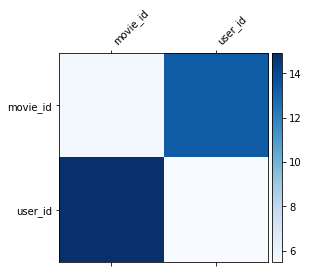

In [34]:
model = dcn_result["model"][4]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

Test

In [35]:
model.evaluate(cached_test)

25/25 [==============================] - 0s 6ms/step - RMSE: 0.9101 - loss: 0.8284 - regularization_loss: 0.0000e+00 - total_loss: 0.8284


[0.9101490378379822, 0.8290325403213501, 0, 0.8290325403213501]

In [36]:
dcn_result['model'][-1].evaluate(cached_test, return_dict=True)

25/25 [==============================] - 0s 5ms/step - RMSE: 0.9101 - loss: 0.8284 - regularization_loss: 0.0000e+00 - total_loss: 0.8284


{'RMSE': 0.9101490378379822,
 'loss': 0.8290325403213501,
 'regularization_loss': 0,
 'total_loss': 0.8290325403213501}

In [37]:
my_list = [dcn_result, dcn_lr_result, dnn_result, dcn_parallel_result,dcn_parallel2_result, dcn_parallel3_result]
my_model_name = ["DCN Base", "DCN with LR", "DNN ", "Parallel", "Parallel 2", "Parallel 3"]
print('Testing on test data.. ')
for i,name in enumerate(my_list):
  print("#"+str(i)+ " " +str(my_model_name[i]), end=" ")
  result = name['model'][-1].evaluate(cached_test,return_dict=True, verbose=False)
  print('\t\t RMSE: {:.2f}'.format(result['RMSE']))

  # print("DNN (parallel2) RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_parallel2_result["mean"]))

Testing on test data.. 
#0 DCN Base 		 RMSE: 0.91
#1 DCN with LR 		 RMSE: 0.89
#2 DNN  		 RMSE: 0.90
#3 Parallel 		 RMSE: 0.91
#4 Parallel 2 		 RMSE: 0.90
#5 Parallel 3 		 RMSE: 0.89


In [38]:
model_tmp.predict(cached_test)

array([[3.919224 ],
       [3.7159245],
       [3.7252152],
       ...,
       [3.468406 ],
       [3.5185535],
       [2.3079493]], dtype=float32)

In [ ]:
#predict function created

In [135]:
# N = 100
# # dictionary of arrays:
# # metadata = {
# #     'bucketized_user_age': "1",
# #     'movie_id': '1416',
# #     'movie_title': 'Thunderball (1965)',
# #     'timestamp': "975658116",
# #     'user_gender': "1",
# #     'user_id': '1285',
# #     'user_occupation_text': 'college/grad student',
# #     'user_rating': "4.0",
# #     'user_zip_code': '98125'
# #     }

# metadata = {
#     'bucketized_user_age': "1",
#     'movie_id': '1416',
#     'movie_title': 'Thunderball (1965)',
#     'timestamp': "975658116",
#     'user_gender': "1",
#     'user_id': '1285',
#     'user_occupation_text': 'college/grad student',
#     'user_rating': "4.0",
#     'user_zip_code': '98125'
#     }
# num_samples = N

# def meta_dict_gen():
#     for i in range(num_samples):
#         ls = {}
#         for key, val in metadata.items():
#             ls[key] = val[i]
#         yield ls

# dataset = tf.data.Dataset.from_generator(
#     meta_dict_gen,
#     output_types={"movie_id": tf.string, "user_id": tf.string, "user_rating": tf.float32, "user_gender": tf.int32, "user_zip_code": tf.string, "user_occupation_text": tf.string, "movie_title": tf.string, "timestamp": tf.int32, "bucketized_user_age": tf.int32},
#     output_shapes={"movie_id": (), "user_id": (), "user_rating": (), "user_gender": (), "user_zip_code": (), "user_occupation_text": (), "movie_title": (), "timestamp": (), "bucketized_user_age": ()})

In [41]:
import os

In [47]:
os.listdir("KT_DCN/ml-1m/")

['movies.csv', 'ratings.csv']

In [49]:
import pandas as pd
my_rating = pd.read_csv("KT_DCN/ml-1m/ratings.csv", usecols=["user_id","movie_id","rating"])
my_rating.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [55]:
my_rating.nunique()

user_id     6040
movie_id    3706
rating         5
dtype: int64

In [19]:
# print(my_rating.groupby("userId").groups)

In [51]:
pref_matrix = my_rating.reset_index()[["user_id", "movie_id", "rating"]].pivot(index="user_id", columns="movie_id", values="rating")
pref_matrix = pref_matrix.fillna(0)
pref_matrix.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [52]:
my_test_dict = pref_matrix.to_dict()

In [53]:
userId = list(pref_matrix.index)
movieId = list(pref_matrix.columns)

In [56]:
len(userId), len(movieId)

(6040, 3706)

In [57]:
count =0
final_movie_id = []
final_user_id = []
final_rating = []
for i in my_test_dict.items():
    
    tmp = [i[0] for j in range(len(userId))]
#     print("movie id "+str(tmp))
    final_movie_id.extend(tmp)
    
#     print("user id "+str(list(i[1].keys())))
    final_user_id.extend(list(i[1].keys()))

#     print("ratings id "+str(list(i[1].values())))
    final_rating.extend(list(i[1].values()))
#     count+=1
#     if count>5:
#         break

In [58]:
len(final_movie_id), len(final_user_id), len(final_rating)

(22384240, 22384240, 22384240)

In [59]:
final_movie_id = [str(i) for i in final_movie_id]
final_user_id = [str(i) for i in final_user_id]

In [60]:
N = len(final_movie_id)
# dictionary of arrays:
# metadata = {
#     'bucketized_user_age': "1",
#     'movie_id': '1416',
#     'movie_title': 'Thunderball (1965)',
#     'timestamp': "975658116",
#     'user_gender': "1",
#     'user_id': '1285',
#     'user_occupation_text': 'college/grad student',
#     'user_rating': "4.0",
#     'user_zip_code': '98125'
#     }

metadata = {
    'movie_id': final_movie_id,
    'user_id': final_user_id,
    'user_rating': final_rating,
    }
num_samples = N

def meta_dict_gen():
    for i in range(num_samples):
        ls = {}
        for key, val in metadata.items():
            ls[key] = val[i]
        yield ls

dataset = tf.data.Dataset.from_generator(
    meta_dict_gen,
    output_types={"movie_id": tf.string, "user_id": tf.string, "user_rating": tf.float32},
    output_shapes={"movie_id": (), "user_id": (), "user_rating": ()})

In [61]:
# dataset = dataset.map(lambda x: {
#     "movie_id": x["movie_id"],
#     "user_id": x["user_id"],
#     "user_rating": x["user_rating"],
#     "user_gender": int(x["user_gender"]),
#     "user_zip_code": x["user_zip_code"],
#     "user_occupation_text": x["user_occupation_text"],
#     "movie_title": x["movie_title"],
#     "timestamp": int(x["timestamp"]),
#     "bucketized_user_age": int(x["bucketized_user_age"]),
# })

dataset = dataset.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

In [62]:
for x in dataset.batch(1).take(2).as_numpy_iterator():
  pprint.pprint(x)

{'movie_id': array([b'1'], dtype=object),
 'user_id': array([b'1'], dtype=object),
 'user_rating': array([5.], dtype=float32)}
{'movie_id': array([b'1'], dtype=object),
 'user_id': array([b'2'], dtype=object),
 'user_rating': array([0.], dtype=float32)}


In [63]:
6083286/4096

1485.17724609375

In [64]:
cached_test_dataset = dataset.batch(4096).cache()

In [65]:
%%time

preds = model_tmp.predict(cached_test_dataset,verbose=True)
preds = preds.flatten()

5465/5465 [==============================] - 3440s 629ms/step
CPU times: user 1h 3min 31s, sys: 9min 16s, total: 1h 12min 48s
Wall time: 57min 20s


In [66]:
final_predicted_rating = [i for i in preds.flatten()]

In [67]:
len(final_predicted_rating)

22384240

In [71]:
final_predicted_rating[:5]

[4.295855, 4.141455, 4.532125, 4.0342045, 3.2023442]

In [72]:
result_df = pd.DataFrame(data = list(zip(final_user_id,final_movie_id,final_rating,final_predicted_rating)),columns=['UserId','movieId','rating','predicted_rating'])

In [73]:
result_df.head()

,UserId,movieId,rating,predicted_rating
0,1,1,5.0,4.295855
1,2,1,0.0,4.141455
2,3,1,0.0,4.532125
3,4,1,0.0,4.034204
4,5,1,0.0,3.202344


In [74]:
result_df['final_score'] = result_df['rating']
result_df.head()

,UserId,movieId,rating,predicted_rating,final_score
0,1,1,5.0,4.295855,5.0
1,2,1,0.0,4.141455,0.0
2,3,1,0.0,4.532125,0.0
3,4,1,0.0,4.034204,0.0
4,5,1,0.0,3.202344,0.0


In [75]:
final2_df = result_df[result_df["final_score"]==0.0]

In [78]:
os.listdir("KT_DCN")

['dcn v6-KT.ipynb', '.ipynb_checkpoints', 'ml-1m', 'TFDS']

In [79]:
final2_df.to_pickle("KT_DCN/TFDS/DCN_Result2.pickle")

In [81]:
result_df.to_pickle("KT_DCN/TFDS/DCN_Result.pickle")

In [82]:
temp2 = result_df[result_df['UserId']=="1"].sort_values(by='predicted_rating', ascending=False)[:10]
temp2.head()

,UserId,movieId,rating,predicted_rating,final_score
20336680,1,3607,0.0,4.911602,0.0
17848200,1,3172,0.0,4.886096,0.0
3370320,1,572,0.0,4.883095,0.0
18180400,1,3233,0.0,4.684411,0.0
18790440,1,3338,0.0,4.634354,0.0


In [83]:
temp = pd.read_csv('KT_DCN/ml-1m/movies.csv')

In [84]:
temp.head()

,movie_id,movie,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [85]:
temp.rename(columns = {"movie_id": "movieId","movie":"title"}, inplace = True)

In [86]:
temp.head()

,movieId,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [87]:

temp = temp[['movieId', 'title']]
temp["movieId"] = temp["movieId"].astype(str)
temp.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [88]:
finally_final = final2_df.merge(temp,on="movieId",how="left")

In [89]:
finally_final[finally_final['UserId']=="4"].sort_values(by='predicted_rating', ascending=False)[:10]

,UserId,movieId,rating,predicted_rating,final_score,title
11572753,4,2197,0.0,5.006701,0.0,Firelight (1997)
17826455,4,3323,0.0,4.976559,0.0,Chain of Fools (2000)
282527,4,53,0.0,4.946044,0.0,Lamerica (1994)
3250558,4,578,0.0,4.883179,0.0,"Hour of the Pig, The (1993)"
3720870,4,668,0.0,4.863266,0.0,Pather Panchali (1955)
4295014,4,787,0.0,4.836448,0.0,"Gate of Heavenly Peace, The (1995)"
4637306,4,858,0.0,4.834882,0.0,"Godfather, The (1972)"
15517337,4,2905,0.0,4.827373,0.0,Sanjuro (1962)
19525807,4,3629,0.0,4.805963,0.0,"Gold Rush, The (1925)"
4978838,4,923,0.0,4.796127,0.0,Citizen Kane (1941)


In [90]:
finally_final.head()

,UserId,movieId,rating,predicted_rating,final_score,title
0,2,1,0.0,4.141455,0.0,Toy Story (1995)
1,3,1,0.0,4.532125,0.0,Toy Story (1995)
2,4,1,0.0,4.034204,0.0,Toy Story (1995)
3,5,1,0.0,3.202344,0.0,Toy Story (1995)
4,7,1,0.0,4.160647,0.0,Toy Story (1995)


In [91]:
finally_final.to_pickle("KT_DCN/TFDS/DCN_recommendation_final_result.pkl")

In [47]:
### Experiment with pickle size vs load time tradeoff

In [92]:
import pickle
import pandas as pd

In [94]:
df = pd.read_pickle("KT_DCN/TFDS/DCN_recommendation_final_result.pkl")

In [95]:
df.head()

,UserId,movieId,rating,predicted_rating,final_score,title
0,2,1,0.0,4.141455,0.0,Toy Story (1995)
1,3,1,0.0,4.532125,0.0,Toy Story (1995)
2,4,1,0.0,4.034204,0.0,Toy Story (1995)
3,5,1,0.0,3.202344,0.0,Toy Story (1995)
4,7,1,0.0,4.160647,0.0,Toy Story (1995)


In [96]:
df.tail()

,UserId,movieId,rating,predicted_rating,final_score,title
21384026,6036,3952,0.0,3.472005,0.0,"Contender, The (2000)"
21384027,6037,3952,0.0,3.456575,0.0,"Contender, The (2000)"
21384028,6038,3952,0.0,3.716425,0.0,"Contender, The (2000)"
21384029,6039,3952,0.0,3.544908,0.0,"Contender, The (2000)"
21384030,6040,3952,0.0,2.920799,0.0,"Contender, The (2000)"


In [97]:
df.shape

(21384031, 6)

In [98]:
df.rating.unique()

array([0.])

In [99]:
df.final_score.unique()

array([0.])

In [100]:
df_copy = df[['UserId','movieId','title','predicted_rating']]

In [101]:
df_copy.shape

(21384031, 4)

In [102]:
df_copy.head()

,UserId,movieId,title,predicted_rating
0,2,1,Toy Story (1995),4.141455
1,3,1,Toy Story (1995),4.532125
2,4,1,Toy Story (1995),4.034204
3,5,1,Toy Story (1995),3.202344
4,7,1,Toy Story (1995),4.160647


In [40]:
df_copy.tail()

,UserId,movieId,title,predicted_rating
5983277,667,163949,The Beatles: Eight Days a Week - The Touring Y...,3.641303
5983278,668,163949,The Beatles: Eight Days a Week - The Touring Y...,3.451962
5983279,669,163949,The Beatles: Eight Days a Week - The Touring Y...,3.903868
5983280,670,163949,The Beatles: Eight Days a Week - The Touring Y...,2.308453
5983281,671,163949,The Beatles: Eight Days a Week - The Touring Y...,3.856942


In [103]:
df_copy.to_pickle('KT_DCN/TFDS/dcn_reco_df.pickle') 

In [104]:
%%time
reco_df = pd.read_pickle("KT_DCN/TFDS/dcn_reco_df.pickle")   #size 195 MB

CPU times: user 3.44 s, sys: 2.16 s, total: 5.61 s
Wall time: 5.93 s


In [105]:
reco_df.head()

,UserId,movieId,title,predicted_rating
0,2,1,Toy Story (1995),4.141455
1,3,1,Toy Story (1995),4.532125
2,4,1,Toy Story (1995),4.034204
3,5,1,Toy Story (1995),3.202344
4,7,1,Toy Story (1995),4.160647


In [106]:
reco_df.tail()

,UserId,movieId,title,predicted_rating
21384026,6036,3952,"Contender, The (2000)",3.472005
21384027,6037,3952,"Contender, The (2000)",3.456575
21384028,6038,3952,"Contender, The (2000)",3.716425
21384029,6039,3952,"Contender, The (2000)",3.544908
21384030,6040,3952,"Contender, The (2000)",2.920799


In [34]:
# https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e

In [107]:
import bz2
import _pickle as cPickle

In [108]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
     with bz2.BZ2File(title + '.pbz2', 'w') as f:
            cPickle.dump(data, f)

In [109]:
# Load any compressed pickle file
def decompress_pickle(file):
     data = bz2.BZ2File(file, 'rb')
     data = cPickle.load(data)
     return data

In [110]:
compressed_pickle('KT_DCN/TFDS/dcn_reco_df', df_copy) 

In [111]:
%%time
dcn_reco_df = decompress_pickle('KT_DCN/TFDS/dcn_reco_df.pbz2')  # Size 27.5MB 

CPU times: user 37.3 s, sys: 1.9 s, total: 39.2 s
Wall time: 41.9 s


In [112]:
dcn_reco_df.head()

,UserId,movieId,title,predicted_rating
0,2,1,Toy Story (1995),4.141455
1,3,1,Toy Story (1995),4.532125
2,4,1,Toy Story (1995),4.034204
3,5,1,Toy Story (1995),3.202344
4,7,1,Toy Story (1995),4.160647


In [113]:
dcn_reco_df.tail()

,UserId,movieId,title,predicted_rating
21384026,6036,3952,"Contender, The (2000)",3.472005
21384027,6037,3952,"Contender, The (2000)",3.456575
21384028,6038,3952,"Contender, The (2000)",3.716425
21384029,6039,3952,"Contender, The (2000)",3.544908
21384030,6040,3952,"Contender, The (2000)",2.920799


In [114]:
# Saves the "data" with the "title" and adds the .pickle
def full_pickle(title, data):
    pikd = open(title + '.pickle', 'wb')
    pickle.dump(data, pikd,protocol=pickle.HIGHEST_PROTOCOL)
    pikd.close()

In [115]:
# loads and returns a pickled objects
def loosen(file):
    pikd = open(file, 'rb')
    data = pickle.load(pikd)
    pikd.close()
    return data

In [116]:
full_pickle('KT_DCN/TFDS/dcn_reco_df_v2', df_copy)

In [117]:
%%time
dcn_reco_df_v2 = loosen('KT_DCN/TFDS/dcn_reco_df_v2.pickle')   # 195 MB size

CPU times: user 3.51 s, sys: 2.16 s, total: 5.67 s
Wall time: 6.27 s


In [7]:
# Dict saving not needed (below cells)

In [ ]:
%%time
df_dict = df_copy.to_dict(orient='records')

In [57]:
df_dict[:5]

[{'UserId': '1',
  'movieId': '1',
  'title': 'Toy Story (1995)',
  'predicted_rating': 3.978767156600952},
 {'UserId': '2',
  'movieId': '1',
  'title': 'Toy Story (1995)',
  'predicted_rating': 4.025431156158447},
 {'UserId': '3',
  'movieId': '1',
  'title': 'Toy Story (1995)',
  'predicted_rating': 3.8028371334075928},
 {'UserId': '4',
  'movieId': '1',
  'title': 'Toy Story (1995)',
  'predicted_rating': 4.488399982452393},
 {'UserId': '5',
  'movieId': '1',
  'title': 'Toy Story (1995)',
  'predicted_rating': 3.694321632385254}]

In [61]:
full_pickle('KT_DCN/TFDS/dcn_reco_dict_list', df_dict)

In [62]:
%%time
dcn_reco_dict = loosen('KT_DCN/TFDS/dcn_reco_dict_list.pickle')   # 224 MB size

CPU times: user 3.48 s, sys: 983 ms, total: 4.46 s
Wall time: 4.47 s


In [1]:
# Prediction

In [2]:
import pickle
import pandas as pd

In [3]:
%%time
df_reco_df = pd.read_pickle("KT_DCN/TFDS/dcn_reco_df.pickle")

CPU times: user 4.05 s, sys: 2.19 s, total: 6.23 s
Wall time: 9.28 s


In [4]:
def recommend(userid,n):
    reco_df = df_reco_df[df_reco_df['UserId']==str(userid)].sort_values(by='predicted_rating', ascending=False)[:n]
    reco_df['score_normalized'] = (reco_df['predicted_rating']-min(reco_df['predicted_rating']))/(max(reco_df['predicted_rating'])-min(reco_df['predicted_rating']))
    return_dict = {}
    reco_list_dict = reco_df[['movieId','title']].to_dict(orient='records')
    for i in range(n):
        return_dict.update({i+1 : reco_list_dict[i]})
    return return_dict

In [5]:
rec_dict = recommend(4,5)

In [6]:
print(rec_dict)

{1: {'movieId': '2197', 'title': 'Firelight (1997)'}, 2: {'movieId': '3323', 'title': 'Chain of Fools (2000)'}, 3: {'movieId': '53', 'title': 'Lamerica (1994)'}, 4: {'movieId': '578', 'title': 'Hour of the Pig, The (1993)'}, 5: {'movieId': '668', 'title': 'Pather Panchali (1955)'}}
